In [1]:
import torch
import numpy as np
%load_ext autoreload
%autoreload 2

# Emulating the DRP Object Catalog

### Global config

In [22]:
import json

np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device=='cuda':
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
print("device: ", device)
    
args = json.load(open("args.txt"))

device:  cuda


### Data I/O

In [21]:
from derp_data import DerpData
import itertools

# X base columns
truth_cols = list('ugriz') + ['y_truth', 'ra_truth', 'dec_truth', 'redshift', 'star',]
truth_cols += ['size_bulge_true', 'size_minor_bulge_true', 'ellipticity_1_bulge_true', 'ellipticity_2_bulge_true', 'bulge_to_total_ratio_i']
truth_cols += ['size_disk_true', 'size_minor_disk_true', 'ellipticity_1_disk_true', 'ellipticity_2_disk_true',]
opsim_cols = ['m5_flux', 'PSF_sigma2', 'filtSkyBrightness_flux', 'airmass', 'n_obs']
# Y base columns
drp_cols = ['x', 'y_obs', 'ra_obs', 'dec_obs', 'Ixx', 'Ixy', 'Iyy', 'IxxPSF', 'IxyPSF', 'IyyPSF',] #'extendedness',]
drp_cols_prefix = ['cModelFlux_', 'psFlux_']
drp_cols_suffix = ['_base_CircularApertureFlux_70_0_instFlux','_ext_photometryKron_KronFlux_instFlux',]
drp_cols += [t[0] + t[1] for t in list(itertools.product(drp_cols_prefix, list('ugrizy')))]
drp_cols += [t[1] + t[0] for t in list(itertools.product(drp_cols_suffix, list('ugrizy')))]

# Define dataset
data = DerpData(data_path='raw_data/obj_master.csv', X_base_cols=truth_cols + opsim_cols, Y_base_cols=drp_cols, 
                verbose=args['verbose'], ignore_null_rows=True, save_to_disk=True)
X_cols = data.X_cols
Y_cols = data.Y_cols
X_cat_mapping = data.X_cat_mapping
n_trainval = data.n_trainval
n_train = data.n_train
n_val = n_trainval - n_train
X_dim = data.X_dim
Y_dim = data.Y_dim

/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Deleting null rows: 85049 --> 79318
Standardized X except:  ['not_star']
Standardized Y except:  []
Saving processed data to disk...


In [23]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

# Split train vs. val
train_sampler = SubsetRandomSampler(data.train_indices)
val_sampler = SubsetRandomSampler(data.val_indices)

# Define dataloader
kwargs = {'num_workers': 1, 'pin_memory': True} if device=='cuda' else {}
train_loader = DataLoader(data, batch_size=args['batch_size'], sampler=train_sampler, **kwargs)
val_loader = DataLoader(data, batch_size=args['batch_size'], sampler=val_sampler, **kwargs)

In [24]:
for batch_idx, (X_batch, Y_batch) in enumerate(val_loader):
    print(X_batch.shape)
    print(Y_batch.shape)
    break

torch.Size([1000, 24])
torch.Size([1000, 34])


### Model

In [25]:
from models import ConcreteDense

length_scale = args['l']
wr = length_scale**2.0/data.n_train
dr = 2.0/data.n_train
model = ConcreteDense(data.X_dim, data.Y_dim, args['n_features'], wr, dr)

print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
linear1.weight 	 torch.Size([1024, 24])
linear1.bias 	 torch.Size([1024])
linear2.weight 	 torch.Size([1024, 1024])
linear2.bias 	 torch.Size([1024])
linear3.weight 	 torch.Size([1024, 1024])
linear3.bias 	 torch.Size([1024])
linear4_mu.weight 	 torch.Size([34, 1024])
linear4_mu.bias 	 torch.Size([34])
linear4_logvar.weight 	 torch.Size([34, 1024])
linear4_logvar.bias 	 torch.Size([34])
conc_drop1.p_logit 	 torch.Size([1])
conc_drop2.p_logit 	 torch.Size([1])
conc_drop3.p_logit 	 torch.Size([1])
conc_drop_mu.p_logit 	 torch.Size([1])
conc_drop_logvar.p_logit 	 torch.Size([1])


### Training

In [26]:
from optim import fit_model

X_val = data.X[data.val_indices, :]
Y_val = data.Y[data.val_indices, :]
model, pppp, rmse = fit_model(model, args['n_epochs'], train_loader, val_loader, n_val=data.n_val,
                             device=device, logging_interval=args['logging_interval'],
                             X_val=X_val, Y_val=Y_val, n_MC=args['n_MC'], run_id=args['run_id'])

Epoch 2 done
Epoch 4 done
Epoch 6 done
Epoch 8 done
Epoch 10 done
Epoch 12 done
Epoch 14 done
Epoch 16 done
Epoch 18 done
Epoch 20 done


Text(0.5,1,'RMSE')

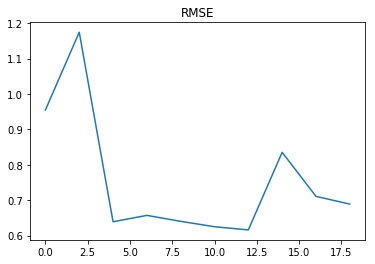

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.arange(0, args['n_epochs'], args['logging_interval']),
         rmse)
plt.title("RMSE")

Text(0.5,1,'Per-point predictive probability')

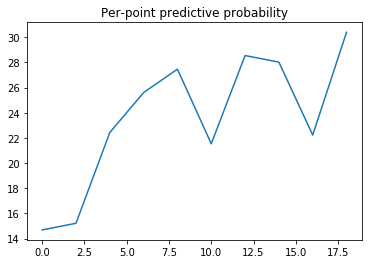

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.arange(0, args['n_epochs'], args['logging_interval']),
         pppp)
plt.title("Per-point predictive probability")

### Export post-training metadata

In [29]:
data.export_metadata_for_eval(device_type=device.type)